In [1]:
from ay_torch import *

In [2]:
FUNC_KIND=3
def Func(x):
  #NOTE: Switch the function to be learned.
  global FUNC_KIND
  if FUNC_KIND==0:  return x
  if FUNC_KIND==1:  return (x[:,0]**2).reshape((-1,1))
  if FUNC_KIND==2:  return (3.0-x[:,0]).reshape((-1,1))
  if FUNC_KIND==3:  return (x[:,0]+3.0*np.sin(x[:,0])).reshape((-1,1))
  if FUNC_KIND==4:  return np.where(x[:,0]**2<1.0, 3.0, 0.0).reshape((-1,1))

def GenerateSample(xmin, xmax, N_sample, f, noise=1.0e-10):
  data_x= np.random.uniform(xmin,xmax,size=(N_sample,1))
  data_y= f(data_x) + np.random.normal(scale=noise,size=(N_sample,1))
  return data_x,data_y

In [3]:
xmin,xmax= -5.0, 5.0
N_sample= 200
#NOTE: Adjust the sample size and noise level.
data_x,data_y= GenerateSample(xmin, xmax, N_sample, Func, noise=0.5)

#Convert data to torch variables.
data_x= torch.autograd.Variable(torch.from_numpy(data_x).float())
data_y= torch.autograd.Variable(torch.from_numpy(data_y).float())

#NOTE: Adjust the batch and epoch sizes.
N_batch= 50

#Make torch dataset and loader.
test_ratio= 0.2
idxes= np.random.RandomState(seed=42).permutation(data_x.shape[0])
N_train= round(data_x.shape[0]*(1.-test_ratio))
dset_train= torch.utils.data.TensorDataset(data_x[idxes[:N_train]], data_y[idxes[:N_train]])
dset_test= torch.utils.data.TensorDataset(data_x[idxes[N_train:]], data_y[idxes[N_train:]])
dl_train= torch.utils.data.DataLoader(
      dataset=dset_train,
      batch_size=N_batch,
      shuffle=True,
      num_workers=2)
dl_test= torch.utils.data.DataLoader(
      dataset=dset_train,
      batch_size=N_batch,
      shuffle=True,
      num_workers=2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
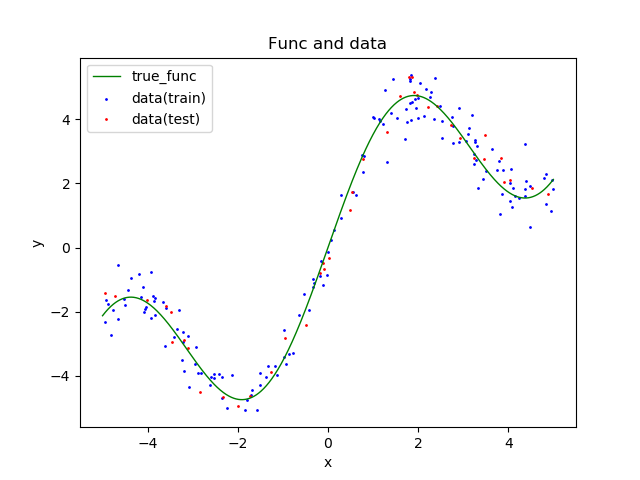

In [4]:
%matplotlib widget
fig= plt.figure()
ax_pred= fig.add_subplot(1,1,1,title='Func and data',xlabel='x',ylabel='y')
true_x= np.linspace(xmin,xmax,1000).reshape((-1,1))
ax_pred.plot(true_x, Func(true_x), color='green', linewidth=1, label='true_func')
ax_pred.scatter(data_x[idxes[:N_train]], data_y[idxes[:N_train]], 1, color='blue', label='data(train)')
ax_pred.scatter(data_x[idxes[N_train:]], data_y[idxes[N_train:]], 1, color='red', label='data(test)')
ax_pred.legend()

In [5]:
class TRegNN1(torch.nn.Module):
  def __init__(self):
    super(TRegNN1,self).__init__()
    self.lin1= torch.nn.Linear(in_features=1, out_features=1, bias=True)
  def forward(self, x):
    x= self.lin1(x)
    return x

def DefRegNN2():
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(200, 100),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(100, 1),
          )

def DefRegNN3():
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 1),
          )

def DefRegNN4():
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 1),
          )

def DefRegNN5(p=0.02):
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 1),
          )

In [6]:
def _f_test(x):
  return x*x*x
# fl= TFuncList((lambda x: x+1, lambda x: x*x)) + TFuncList((lambda x: x*x*x,))
# fl= TFuncList((lambda x: x+1, lambda x: x*x)) + [lambda x: x*x*x]
# fl= TFuncList((lambda x: x+1, lambda x: x*x)) + (lambda x: x*x*x)
# fl= TFuncList((lambda x: x+1, lambda x: x*x)) + TFuncList((_f_test,))
fl= TFuncList((lambda x: x+1, lambda x: x*x)) + _f_test
# fl+= [_f_test]
fl+= _f_test
# fl= TFuncList()
fl(x=10)
# type(fl)
# f1

[11, 100, 1000, 1000]

In [7]:
class _TFLTest(object):
  def __init__(self):
    self.x= 100
  def FL(self):
    return TFuncList((lambda y,self=self: self.x*y,lambda y,self=self: self.x+y+11))
flt= _TFLTest()
fl= flt.FL()
flt.x= 150
fl(10)

[1500, 171]

In [8]:
# Function forward test:
def f1(x, y=None, *args, **kwargs):
  print(x,y)
def f2(*args, **kwargs):
  f1(*args, **kwargs)
f2(100,y=100)

100 100


In [9]:
d1={1:1,2:2}
d2={2:3,3:3}
d3= d2
d4={3:4,5:5}
d3= MergeDict(d1, [d3,d4])
# d3= MergeDictSum(d1, [d3,d4])
print(d1,d2,d3)

{1: 1, 2: 3, 3: 4, 5: 5} {2: 3, 3: 3} {1: 1, 2: 3, 3: 4, 5: 5}


In [10]:
d1={1:[1],2:[2]}
d2={2:[3],3:[3]}
d3= d2
d4={3:[4],5:[5]}
# d3= MergeDict(d1, [d3,d4])
d3= MergeDictSum(d1, [d3,d4])
print(d1,d2,d3)

{1: [1], 2: [2, 3], 3: [3, 4], 5: [5]} {2: [3], 3: [3, 4]} {1: [1], 2: [2, 3], 3: [3, 4], 5: [5]}


In [11]:
#Setup a neural network.
#net= TRegNN1()
#net= DefRegNN2()
#net= DefRegNN3()
#net= DefRegNN4()
net= DefRegNN5()

device= torch.device('cpu')
# device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
#opt= torch.optim.SGD(net.parameters(), lr=0.004)
#opt= torch.optim.SGD(net.parameters(), lr=0.002, momentum=0.95)
#opt= torch.optim.Adadelta(net.parameters(), rho=0.9, eps=1e-8)
#opt= torch.optim.Adagrad(net.parameters())
#opt= torch.optim.RMSprop(net.parameters())
f_loss= torch.nn.MSELoss()
#f_loss= torch.nn.HuberLoss(reduction='mean', delta=0.1)

def rmse(y,y_trg):
  return torch.sqrt(torch.nn.functional.mse_loss(y,y_trg))
f_metric= rmse

def tfm_batch(batch):
  x,y= batch
  return torch.autograd.Variable(x), torch.autograd.Variable(y)
logger= TLogger()
disp= TDisp()

In [12]:
next(net.parameters()).device==torch.device('cpu')

True

loss(train)	loss(test)	metric(test)	time
18.30306697	7.49433708	2.72238368	0.184354
7.42388022	7.96459222	2.81963116	0.095181
7.65677893	7.59790397	2.74556541	0.092384
5.41493851	4.55304205	2.11421293	0.106417
4.04720628	3.91186929	1.97081786	0.081630


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
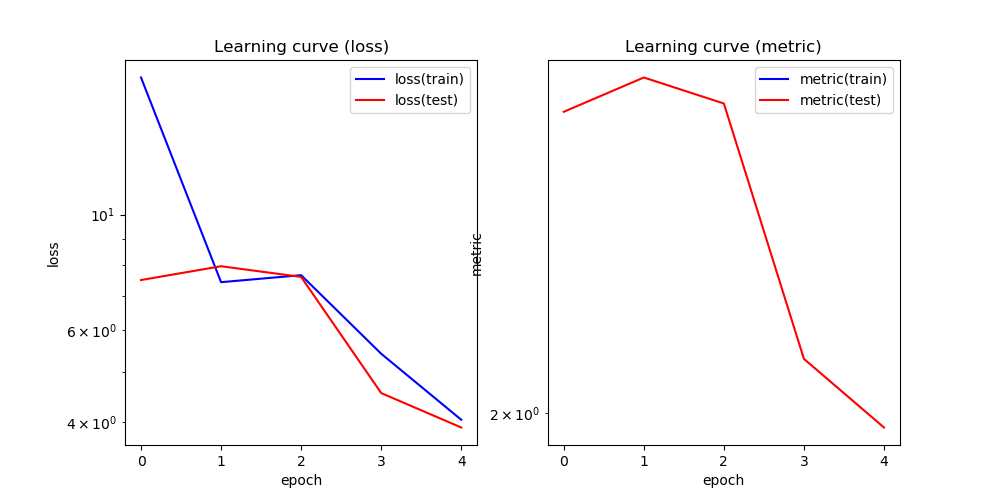

In [13]:
Fit(net, 5, opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()

In [16]:
len(logger.loss_test)

10

In [20]:
[pg['lr'] for pg in opt.param_groups]
[pg.keys() for pg in opt.param_groups]
# opt
opt.state_dict()
# f_loss.state_dict()
# float('inf')

{'state': {},
 'param_groups': [{'lr': 0.01,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
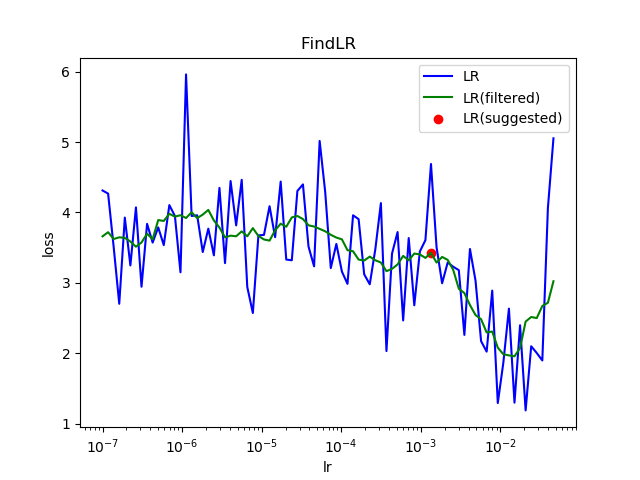

lr= 0.0013489628825916527


In [15]:
lr,_= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}')

loss(train)	loss(test)	metric(test)	time
4.11667776	3.84678662	1.94369870	0.127964
3.02041560	2.89767259	1.69851077	0.109063
3.37227148	3.02019507	1.73666868	0.113580
3.18692738	3.06434321	1.74654919	0.094147
2.93159544	2.54095048	1.57629052	0.106753


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
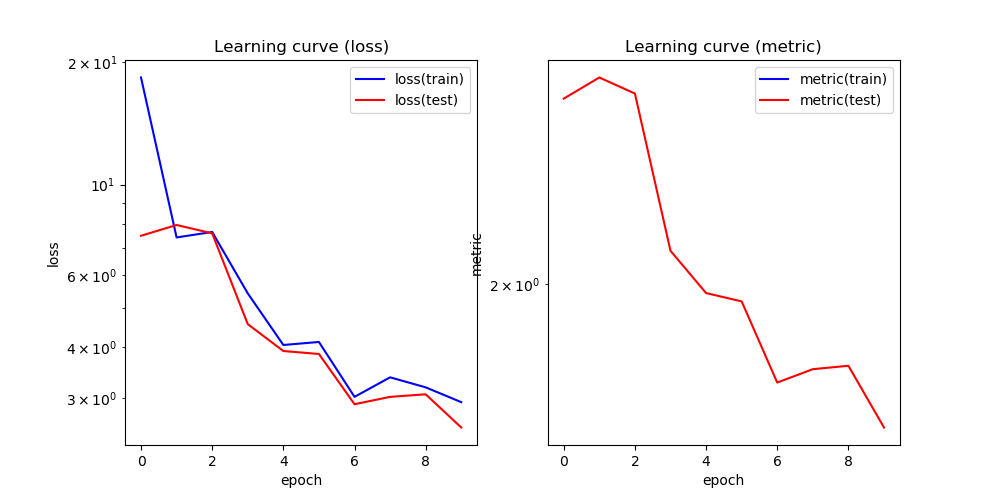

In [16]:
Fit(net, n_epoch=5, lr=lr, opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
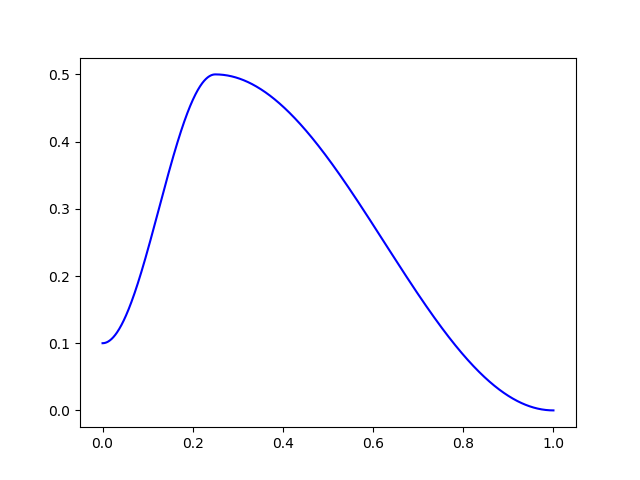

In [24]:
# via_pos= np.array([0,0.1,0.23,0.5,0.8,1.0])
# pos= np.array([0.0, 0.12, 1.2]).reshape(-1,1)
# max(0,min(len(via_pos)-2, sum(pos>=via_pos)-1))
# np.sum(pos>=via_pos,axis=1)
# cosa= lambda start,end,pos: start + (1 + np.cos(np.pi*(1-pos))) * (end-start) / 2
# sch= TScheduler('exp', 1, 0.1)
sch= TCmbScheduler(((0,0.1),(0.25,0.5),(1.0,1e-5)), ('cos','cos'))
fig, ax_loss= plt.subplots(1,1)
X= np.linspace(0,1,1000)
ax_loss.plot(X, [sch(x) for x in X], color='blue', label='LR')

In [25]:
TFuncList([TScheduler('exp', s, e) for s,e in zip([0.01,0.1],[1,10])])(0.2)

[0.0251188643150958, 0.251188643150958]

In [26]:
(lambda p: (TCmbScheduler(((0,0.1),(0.25,0.5),(1.0,1e-5)), ('cos','cos'))(p),
            TCmbScheduler(((0,np.array([0.1,0.01])),(0.25,np.array([0.5,0.05])),(1.0,np.array([1e-5,1e-6]))), ('cos','cos'))(p)))(0.5)

(0.37500250000000007, array([0.3750025 , 0.03750025]))

In [27]:
# learn.lr_find()
# learn.fit_one_cycle(10, 0.006); moms=(0.95,0.85,0.95)
torch.optim.SGD(torch.nn.Linear(1,1).parameters(), lr=0.002, momentum=0.95).param_groups
# torch.optim.Adam(torch.nn.Linear(1,1).parameters(), lr=0.002).param_groups

[{'params': [Parameter containing:
   tensor([[-0.5347]], requires_grad=True),
   Parameter containing:
   tensor([0.8856], requires_grad=True)],
  'lr': 0.002,
  'momentum': 0.95,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False}]

loss(train)	loss(test)	metric(test)	time
2.66929257	2.29031396	1.51263070	0.132256
3.43721870	21.87955713	4.66991556	0.119989
9.81997681	6.14040887	2.47609687	0.098732
5.93944561	4.21863985	2.04001611	0.094929
3.03259987	1.90785715	1.37729084	0.087357
1.44246390	1.22697294	1.09839699	0.078732
1.55206138	0.86242324	0.91269860	0.097111
0.97154322	1.01336096	0.97735521	0.120768
0.89517733	0.75038433	0.86047907	0.085373
0.86481331	0.77857009	0.87672734	0.096406


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
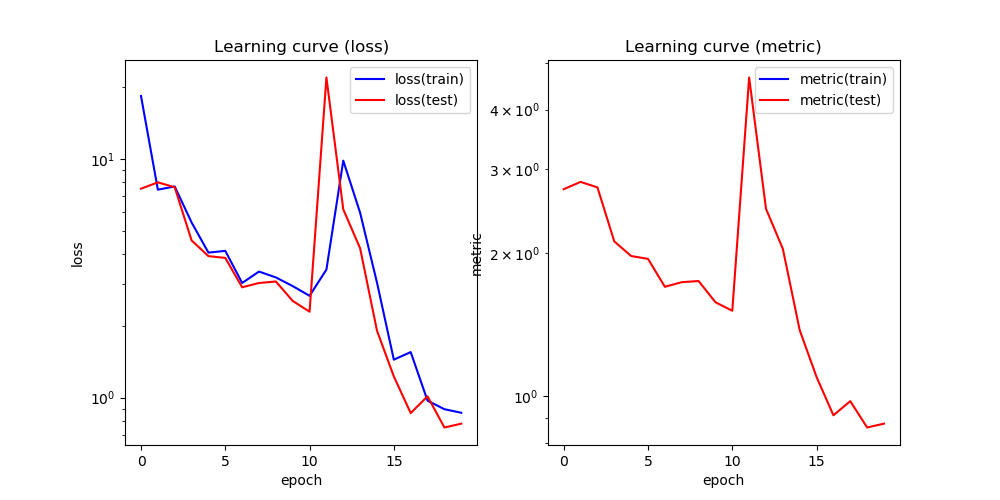

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
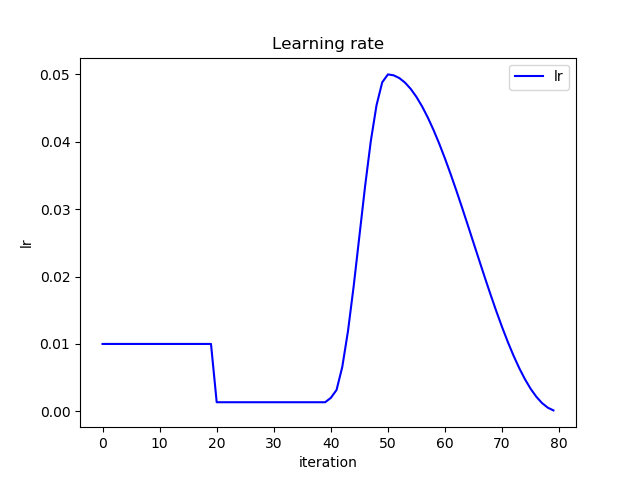

In [17]:
FitOneCycle(net, n_epoch=10, lr_max=0.05, opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
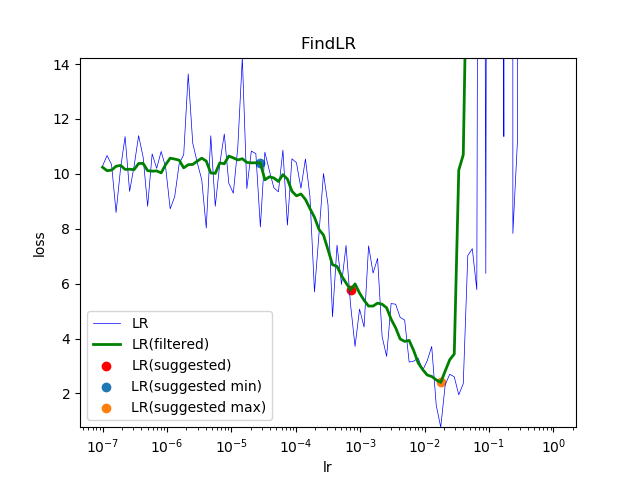

lr= 0.0007079457843841385, lr_min=2.818382931264453e-05, lr_max=0.017782794100389226


In [13]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

loss(train)	loss(test)	metric(test)	time
9.70137858	8.57246542	2.92509878	0.170522
6.45079660	20.81401491	4.55411780	0.131425
10.72569525	8.09218574	2.82818902	0.148567
7.72747827	5.48195219	2.33883852	0.113789
4.06351858	8.43621230	2.88731951	0.127414
3.96946084	3.93820691	1.97280124	0.130077
2.83975798	3.70225096	1.90741995	0.165482
2.16972890	2.04122883	1.42657271	0.135967
1.84360215	1.53991240	1.23827755	0.146753
1.56727555	0.56409130	0.75059837	0.125262
0.98320930	1.23040573	1.10378644	0.135854
1.08817872	0.51470247	0.71388827	0.140888
0.55903481	0.31107591	0.55505759	0.146528
0.57152666	0.32507083	0.56674475	0.120169
0.57300892	0.39583702	0.62712419	0.122088
0.37989686	0.36428367	0.60316506	0.137840
0.41612986	0.28375145	0.52918300	0.121814
0.38350484	0.26402692	0.51122761	0.133223
0.38036788	0.28679845	0.53416330	0.138115
0.37706362	0.24816141	0.49076245	0.118522


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
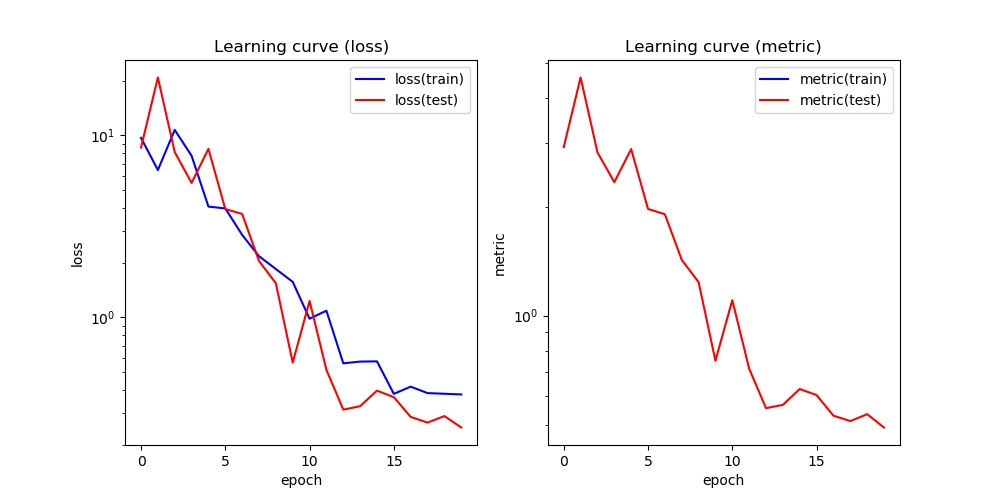

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
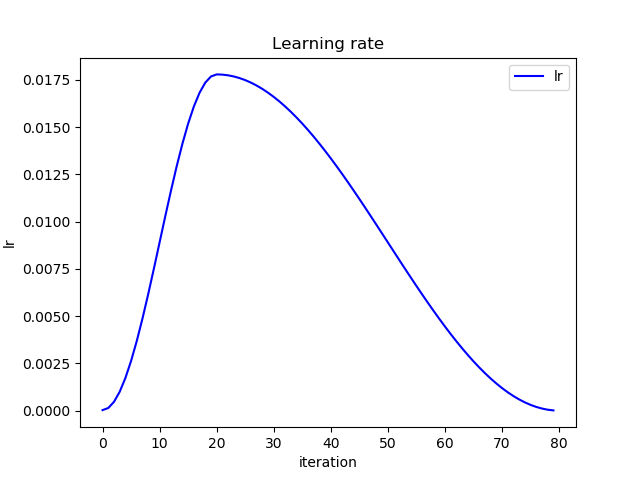

In [14]:
FitOneCycle(net, n_epoch=20, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()